In [1]:
#  imported the essential libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from geopy.distance import geodesic
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# read the file 
lcl_df = pd.read_csv("operational_excellence on_time_execution 2025-04-16T2128.csv")
pd.set_option('display.max_columns', None)
lcl_df.head()

,Shipments: Client Client ID,Shipments: Attributes Ocean type category,Shipments: Attributes Ocean LCL subcategory,Shipments: Attributes Shipment ID,Shipments: Locations Departure port Ocean LOC,Shipments: Locations Final port Ocean LOC,Shipment Containers: Actual Timeline (local) Departure Port Departed On Date,Shipments: Attributes Tradelane,On Time Performance OTP Promised Delivery Week,On Time Performance OTP Promised Delivery Date,Shipment Containers: Actual Timeline (local) In Full Delivered On Date,On Time Performance Primary Delay Stage,Transit Time: Quote Quoted Origin Total Days,On Time Performance Quoted Port to Port Days,On Time Performance Quoted Destination Total Days,On Time Performance Actual Origin Total Days,On Time Performance Actual Port to Port Days,On Time Performance Actual Destination Total Days,Shipments: Attributes CO2 Emissions (Tonnes),Shipments: Attributes Gross Weight (kg),Shipments: Attributes Volume (cbm),Shipment Containers: Distance Final Port to Destination Distance in mile,Shipment Containers: Distance Origin to First Port Distance in km,Shipments: Involved Parties Destination Agent Company Name,Shipments: Involved Parties Origin Agent Company Name,Shipments: Involved Parties To Destination Carrier Name,Shipments: Locations Destination Coordinates,Shipments: Locations Origin Coordinates,Shipments: Attributes Freight Type,Shipments: Locations Arrival port Coordinates,Shipments: Locations Departure port Coordinates,On Time Performance Origin on Time Performance,On Time Performance Port to Port on Time Performance,On Time Performance Destination on Time Performance,On Time Performance On Time Performance,Port pair,Total Quoted Days,Total Actual Days,Delta quoted vs actual total days,Delta actual vs quoted origin days,Delta actual vs quoted p2p days,Delta actual vs quoted destination days
0,76528,coloaded_lcl,Shipco Transport,3051512,DEHAM,USATL,2025-03-11,TAWB,2025-04-07,2025-04-08,2025-04-14,Origin_Terminal,13.0,38.0,4.0,27.0,30.7,12.5,0.07,323,2.622,160.13,358.66,Flexport,Flexport Carrier Booking Operations,Special Service Freight Company,"34.8524089,-82.1421987","50.8720702,6.9040396",Port to Door,"32.7764749,-79.93105120000001","53.5510846,9.9936819",0.0%,100.0%,100.0%,0.0%,DEHAM - USATL,55,70.0,15.0,14.0,-7.0,8.0
1,11690,coloaded_lcl,ECU Worldwide,3065451,DEHAM,USCHI,2025-03-14,TAWB,2025-04-07,2025-04-10,2025-04-07,On Time,15.0,25.0,5.0,18.0,21.3,5.5,0.09,490,0.538,30.83,346.84,Flexport,Flexport Carrier Booking Operations,"Pronto Freightways, Inc.","41.8554967,-87.8144195","50.8163314,7.368568199999999",Door to Door,"45.5016889,-73.567256","53.5510846,9.9936819",0.0%,100.0%,100.0%,100.0%,DEHAM - USCHI,45,45.0,0.0,3.0,-4.0,0.0
2,74791,coloaded_lcl,Shipco Transport,3022941,BDCGP,USLAX,2025-01-29,TPEB,2025-04-07,2025-04-10,2025-03-19,On Time,13.0,58.0,2.0,2.6,48.5,6.2,0.40,"1,913",11.360,54.37,233.94,Flexport,Dart Global Logistics (PVT) - Bangladesh,"ARC Logistics, Inc.","34.0281946,-117.3784815","23.9304077,90.2643401",Port to Door,"34.0522342,-118.2436849","22.356851,91.7831819",100.0%,100.0%,100.0%,100.0%,BDCGP - USLAX,73,57.0,-16.0,-10.0,-9.0,4.0
3,83962,coloaded_lcl,Shipco Transport,3024506,INNSA,GBFXT,2025-02-01,FEWB,2025-04-07,2025-04-08,2025-03-19,On Time,15.0,56.0,4.0,9.5,41.2,6.6,0.26,752,0.508,147.02,421.03,Flexport Carrier Booking Operations,Contech Logistics Solutions Pvt. Ltd.,Lombard,"51.9165818,-2.0997262","22.1572507,70.7990772",Door to Door,"51.961726,1.351255","18.9499361,72.9511875",100.0%,100.0%,0.0%,100.0%,INNSA - GBFXT,75,57.0,-18.0,-5.0,-15.0,3.0
4,46128,flxt_lcl,flxt_lcl_child,3055002,TWKHH,USLAX,2025-02-23,TPEB,2025-04-07,2025-04-09,2025-03-25,On Time,13.0,35.0,9.0,12.4,17.5,13.1,4.38,"6,471",8.110,"1,793.56",296.68,Flexport,"PGS (Taiwan) Logistics Co., Ltd",Flock Freight Inc,"41.6924245,-86.80212759999999","25.0169826,121.4627868",Port to Door,"34.0522342,-118.2436849","22.6272784,120.3014353",100.0%,100.0%,0.0%,100.0%,TWKHH - USLAX,57,43.0,-14.0,-1.0,-18.0,4.0


In [3]:
# list of columns which are not a predictor 
INITIAL_DROP_COLS = [
    'Shipments: Attributes Shipment ID',
    'Shipments: Client Client ID',
    'Shipments: Attributes Ocean LCL subcategory',
    'Shipments: Locations Destination Coordinates',
    'Shipments: Locations Origin Coordinates',
    'Total Quoted Days',
    'Port pair',
    'On Time Performance OTP Promised Delivery Week',
    'Shipment Containers: Actual Timeline (local) In Full Delivered On Date',
    'On Time Performance OTP Promised Delivery Date',
    'Transit Time: Quote Quoted Origin Total Days',
    'On Time Performance Quoted Port to Port Days',
    'On Time Performance Quoted Destination Total Days',
    'On Time Performance Actual Origin Total Days',
    'On Time Performance Actual Port to Port Days',
    'On Time Performance Actual Destination Total Days',
    'On Time Performance Origin on Time Performance',
    'On Time Performance Port to Port on Time Performance',
    'On Time Performance Destination on Time Performance',
    'On Time Performance On Time Performance',
    'Delta quoted vs actual total days',
    'Delta actual vs quoted origin days', 'Delta actual vs quoted p2p days',
    'Delta actual vs quoted destination days',
    'On Time Performance Primary Delay Stage',
    'Shipments: Attributes CO2 Emissions (Tonnes)',
]

# dropping those columns
lcl_df.drop(columns=INITIAL_DROP_COLS, inplace=True)


In [4]:
# spitting the co-ordinates and droping it 
lcl_df[['dest_latitude', 'dest_longitude']] = lcl_df['Shipments: Locations Arrival port Coordinates'] \
    .str.split(',', expand=True).astype(float)

lcl_df[['org_latitude', 'org_longitude']] = lcl_df['Shipments: Locations Departure port Coordinates'] \
    .str.split(',', expand=True).astype(float)

# Convert the date column to datetime
lcl_df['Shipment Containers: Actual Timeline (local) Departure Port Departed On Date'] = pd.to_datetime(lcl_df['Shipment Containers: Actual Timeline (local) Departure Port Departed On Date'])

# Extract the day and month
lcl_df['day'] = lcl_df['Shipment Containers: Actual Timeline (local) Departure Port Departed On Date'].dt.weekday
lcl_df['month'] = lcl_df['Shipment Containers: Actual Timeline (local) Departure Port Departed On Date'].dt.month
lcl_df = lcl_df.drop(["Shipments: Locations Arrival port Coordinates",
                      "Shipments: Locations Departure port Coordinates",
                      'Shipment Containers: Actual Timeline (local) Departure Port Departed On Date'], axis=1)


In [5]:
# columns to convert into float data type 
cols_to_convert = [
    'Shipments: Attributes Gross Weight (kg)', 
    'Shipment Containers: Distance Final Port to Destination Distance in mile',
    'Shipment Containers: Distance Origin to First Port Distance in km'
]

# Remove commas and convert to float
lcl_df[cols_to_convert] = lcl_df[cols_to_convert].replace(',', '', regex=True).astype(float)


In [6]:
# 1. Feature Engineering fewb tawb TPEB
# Weight-to-volume ratio
lcl_df['Weight_to_Volume'] = lcl_df['Shipments: Attributes Gross Weight (kg)'] / (lcl_df['Shipments: Attributes Volume (cbm)'] + 1e-6)

# Total shipment distance (km + converted miles)
lcl_df['Total_Shipment_Distance_km'] = lcl_df['Shipment Containers: Distance Origin to First Port Distance in km'] + (lcl_df['Shipment Containers: Distance Final Port to Destination Distance in mile'] * 1.60934)

# calculating the geo distance from the splitted co-ordinates
lcl_df['Geo Distance'] = lcl_df.apply(
    lambda row: geodesic(
        (row['org_latitude'], row['org_longitude']), 
        (row['dest_latitude'], row['dest_longitude'])
    ).km, axis=1
)

# Droping unused or now redundant columns
lcl_df.drop([
    "Shipments: Attributes Gross Weight (kg)",
    "Shipments: Attributes Volume (cbm)",
], axis=1, inplace=True)

# dropping the non available 
lcl_df = lcl_df.dropna()



In [7]:
# list of numerical columns for outliers removal
numeric_cols = [
    'Shipment Containers: Distance Final Port to Destination Distance in mile',
    'Shipment Containers: Distance Origin to First Port Distance in km',
    'Total Actual Days',	
    'dest_latitude',	
    'dest_longitude',	
    'org_latitude',	
    'org_longitude',
    'day',
    'month',	
    'Weight_to_Volume',	
    'Total_Shipment_Distance_km',		
    'Geo Distance',
]
cat_cols = [
    'Shipments: Locations Departure port Ocean LOC',
    'Shipments: Locations Final port Ocean LOC',
    'Shipments: Involved Parties Destination Agent Company Name',
    'Shipments: Involved Parties Origin Agent Company Name',
    'Shipments: Involved Parties To Destination Carrier Name'
]

N = lcl_df[numeric_cols]


In [8]:
# outliers removal 
iso_outliers = IsolationForest(contamination=0.02,random_state=42).fit_predict(N)
lof_outliers = LocalOutlierFactor(n_neighbors=20, contamination=0.02).fit_predict(N)

# Keep rows marked as inliers (1) by both methods
df_clean = lcl_df[(iso_outliers == 1) & (lof_outliers == 1)].copy()


In [9]:
# Prepare X and y
X = df_clean.drop("Total Actual Days", axis=1)
y = df_clean["Total Actual Days"]


In [10]:
def frequency_encode(df, columns):
    for col in columns:
        freq_encoding = df[col].value_counts()
        df[col + '_encoded'] = df[col].map(freq_encoding)
    return df
X = frequency_encode(X, cat_cols)
X.drop(columns=cat_cols, inplace=True)

In [11]:
# One-hot encode 
X = pd.get_dummies(X, columns=[
    'Shipments: Attributes Ocean type category',
    'Shipments: Attributes Tradelane',
    'Shipments: Attributes Freight Type'
    ],
    dtype=int)

In [12]:
X.head()

,Shipment Containers: Distance Final Port to Destination Distance in mile,Shipment Containers: Distance Origin to First Port Distance in km,dest_latitude,dest_longitude,org_latitude,org_longitude,day,month,Weight_to_Volume,Total_Shipment_Distance_km,Geo Distance,Shipments: Locations Departure port Ocean LOC_encoded,Shipments: Locations Final port Ocean LOC_encoded,Shipments: Involved Parties Destination Agent Company Name_encoded,Shipments: Involved Parties Origin Agent Company Name_encoded,Shipments: Involved Parties To Destination Carrier Name_encoded,Shipments: Attributes Ocean type category_coloaded_lcl,Shipments: Attributes Ocean type category_flxt_lcl,Shipments: Attributes Tradelane_FEEB,Shipments: Attributes Tradelane_FEWB,Shipments: Attributes Tradelane_LATAM IB,Shipments: Attributes Tradelane_LATAM OB,Shipments: Attributes Tradelane_ROW,Shipments: Attributes Tradelane_TAEB,Shipments: Attributes Tradelane_TAWB,Shipments: Attributes Tradelane_TPEB,Shipments: Attributes Tradelane_TPWB,Shipments: Attributes Freight Type_Door to Door,Shipments: Attributes Freight Type_Door to Port,Shipments: Attributes Freight Type_Port to Door,Shipments: Attributes Freight Type_Port to Port
0,160.13,358.66,32.776475,-79.931051,53.551085,9.993682,1.0,3.0,123.188359,616.363614,7148.554863,88,27,2019,74,23,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,30.83,346.84,45.501689,-73.567256,53.551085,9.993682,4.0,3.0,910.778976,396.455952,5760.472284,88,179,2019,74,16,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,54.37,233.94,34.052234,-118.243685,22.356851,91.783182,2.0,1.0,168.397873,321.439816,13003.788261,166,824,2019,166,45,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,147.02,421.03,51.961726,1.351255,18.949936,72.951188,5.0,2.0,1480.312047,657.635167,7114.308525,198,293,334,44,360,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,1793.56,296.68,34.052234,-118.243685,22.627278,120.301435,6.0,2.0,797.903724,3183.127850,11203.015045,426,824,2019,605,160,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [13]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [14]:
#  RandomForestRegressor with appropriate parameter
rfg_model = RandomForestRegressor(n_estimators= 2000,
                             max_features= 'sqrt',
                             min_samples_leaf= 1,
                             min_samples_split= 2,
                             max_depth= 20,
                             random_state=0)

# fitting the model
rfg_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=2000,
                      random_state=0)

In [15]:
# prediction from the model
predictions = rfg_model.predict(X_test)

In [16]:
# calculationg mean absolute error and r2_score
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

MAE: 6.90
R²: 0.6758


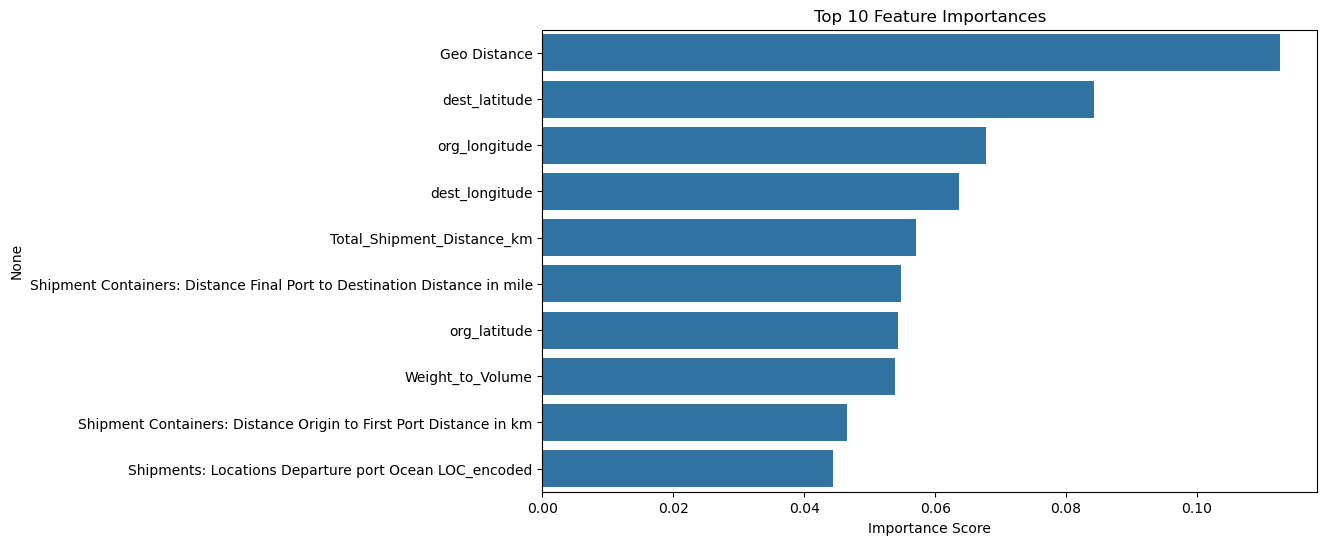

In [17]:

feature_importance = pd.Series(rfg_model.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()


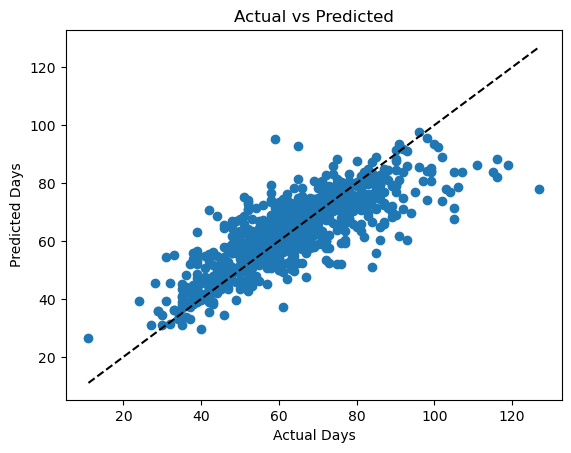

In [18]:
errors = y_test - predictions
plt.scatter(y_test, predictions)
plt.xlabel("Actual Days")
plt.ylabel("Predicted Days")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()


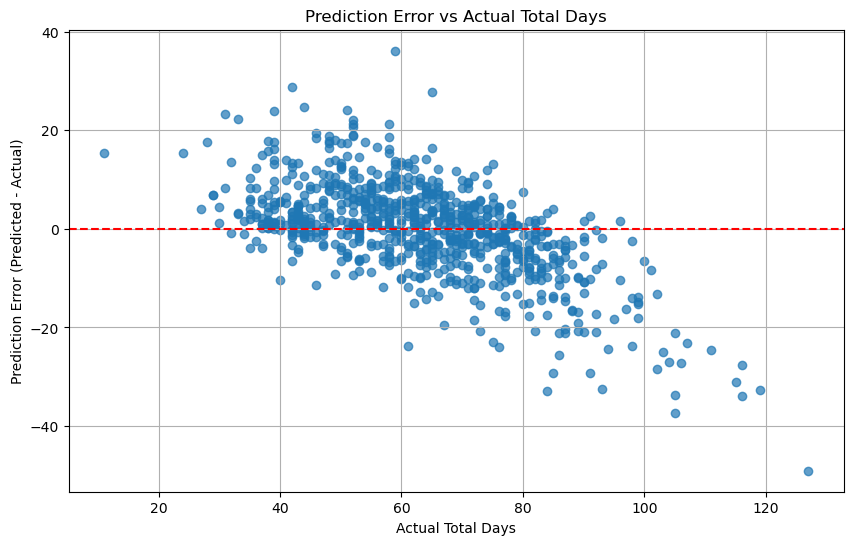

In [19]:

# Calculate residuals (prediction errors)
residuals = predictions - y_test

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Line at y=0 for reference
plt.xlabel("Actual Total Days")
plt.ylabel("Prediction Error (Predicted - Actual)")
plt.title("Prediction Error vs Actual Total Days")
plt.grid(True)
plt.show()
